In [1]:
library(dplyr)
library(ggplot2)
library(data.table)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [2]:
asthma_codes <- as.vector(fread('codesets/asthma_codeset.csv', select=c('concept_id'))$concept_id)

In [3]:
asthma_codes[1:5]

[1]   317009  4155469 44810117 45769441 46269784

In [4]:
albuterol <- fread('codesets/albuterol_codes.csv', select=c('concept_id', 'concept_name'))

In [5]:
nrow(albuterol)

[1] 3025

In [6]:
str(albuterol)

Classes ‘data.table’ and 'data.frame':	3025 obs. of  2 variables:
 $ concept_id  : int  42715193 41490071 40902723 35798286 43615525 21091536 36881999 21148258 41271003 43632161 ...
 $ concept_name: chr  "Albuterol 0.598 MG/ML Inhalant Solution Box of 20" "30000 MG Albuterol 0.00000347 MG/MG Inhalant Solution Box of 300" "Albuterol 20 MG Dry Powder Inhaler [Salbuhexal] Box of 1" "60 ACTUAT Albuterol 0.2 MG/ACTUAT Inhalant Powder [Ventolin] by Sigma-Tau" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
albuterol <- albuterol[grepl("inhal", albuterol$concept_name, ignore.case=TRUE)]

In [8]:
nrow(albuterol)

[1] 3024

In [9]:
inhaled <- as.vector(albuterol$concept_id)

In [10]:
inhaled[1:5]

[1] 42715193 41490071 40902723 35798286 43615525

In [11]:
list.files(path='patient_data')

[1] "condition_occurrence.csv" "drug_exposure.csv"       
[3] "measurement.csv"          "person.csv"              
[5] "visit_occurrence.csv"

In [12]:
condition <- fread('patient_data/condition_occurrence.csv')
drug <- fread('patient_data/drug_exposure.csv')
drug$drug_exposure_start_date <- as.Date(drug$drug_exposure_start_date, '%Y-%m-%d')
measurement <- fread('patient_data/measurement.csv')
measurement$measurement_date <- as.Date(measurement$measurement_date, '%Y-%m-%d')
person <- fread('patient_data/person.csv')
person$birth_datetime <- as.Date(person$birth_datetime, '%Y-%m-%d')
visit <- fread('patient_data/visit_occurrence.csv')
visit$visit_start_date <- as.Date(visit$visit_start_date, '%Y-%m-%d')

Warning message in fread("patient_data/drug_exposure.csv"):
“Discarded single-line footer: <<2371,1>>”

In [13]:
asthma_dx <- condition[condition_concept_id %in% asthma_codes, .(person_id, condition_start_date, visit_occurrence_id)]

In [14]:
latest_date <- as.Date('2018-04-02', '%Y-%m-%d')

In [15]:
setkey(asthma_dx, visit_occurrence_id)
setkey(visit, visit_occurrence_id)
dx <- asthma_dx[visit, nomatch=0][
    , .(person_id, visit_start_date, visit_occurrence_id)
][
    visit_start_date <= latest_date
][
    , .(first_dx = min(visit_start_date), num_visits = uniqueN(visit_occurrence_id)), by=person_id
]

In [16]:
possibles <- dx[num_visits > 1]

In [17]:
print(nrow(dx))
print(nrow(possibles))

[1] 1774
[1] 1461


In [18]:
possibles_ids <- c(possibles$person_id)
scripts <- drug[person_id %in% possibles_ids & drug_concept_id %in% inhaled][
    , .(first_rx = min(drug_exposure_start_date)), by=person_id
]

In [19]:
scripts[person_id == 1003]

person_id,first_rx
1003,2007-02-16


In [20]:
setkey(possibles, person_id)
setkey(scripts, person_id)
asthma_patients <- possibles[scripts, nomatch=0][
    first_rx >= first_dx
]
head(asthma_patients)

person_id,first_dx,num_visits,first_rx
454,2002-11-06,15,2004-03-14
455,2003-02-03,11,2005-12-26
457,2004-12-01,15,2004-12-01
460,2002-12-22,23,2002-12-22
461,2003-05-28,12,2003-08-18
462,2003-03-11,12,2003-03-11


In [21]:
nrow(asthma_patients)

[1] 918

In [22]:
asthma_patient_ids <- c(asthma_patients$person_id)
obese <- measurement[measurement_concept_id == '2000000043' & value_as_number >= 1.645 & measurement_date <= latest_date][
    person_id %in% asthma_patient_ids
][
    , .(BMI_z = mean(value_as_number)), by=c('person_id', 'measurement_date')
][
    , .(person_id, first_obese=measurement_date, BMI_z)
]
head(obese)

person_id,first_obese,BMI_z
560,2005-10-02,1.711458
716,2010-01-05,1.803962
590,2009-06-16,1.905821
1192,2016-04-07,2.645530
2139,2004-04-28,1.714965
905,2012-04-28,2.236804


In [23]:
setkey(obese, person_id)
obese_ids <- asthma_patients[obese, nomatch=0][
    first_obese >= first_dx
][
    , person_id
] %>% unique()

In [24]:
str(obese_ids)

 int [1:379] 454 455 460 468 469 470 472 477 483 494 ...


In [25]:
cohort <- asthma_patients[obese, nomatch=0][
    person_id %in% obese_ids
][
    , .SD[which.min(first_obese)], by=person_id
]
cohort$BMI_z <- round(cohort$BMI_z, 3)

In [26]:
cohort[person_id == 1024]

person_id,first_dx,num_visits,first_rx,first_obese,BMI_z
1024,2004-01-03,19,2004-07-18,2002-07-04,1.938


In [27]:
cohort[, time_between := first_rx - first_dx]

In [28]:
total_obese <- obese[
    person_id %in% asthma_patient_ids
][
    , .(num_obese = .N), by=person_id
]

In [29]:
demog <- person[
    person_id %in% asthma_patient_ids
][
    , .(person_id, age_yrs = birth_datetime, gender = gender_concept_id, ethnicity = ethnicity_concept_id,
        race = race_concept_id)
]

In [30]:
setkey(total_obese, person_id)
setkey(demog, person_id)
cohort <- demog[cohort, nomatch=0][
    total_obese, nomatch=0
]

In [31]:
cohort[, age_first_dx:= round(as.double(difftime(cohort$first_dx, cohort$age_yrs))/365, digits=1)]
cohort$age_yrs <- round(as.double(difftime(latest_date, cohort$age_yrs))/365, digits=1)
cohort[, which_1st:= ifelse(first_obese < first_dx, 'obese', 'asthma')]

In [32]:
keys <- list('8532', '8507', '8515', '8516', '8527', '8557', '8657', '44814649', '44814650', '44814653', '44814659', 
            '44814660', '38003563', '38003564')
values <- list('F', 'M', 'Asian', 'Bl/AfrAm', 'White', 'Hawaii/PacIsl', 'AmInd/Alaska', 'Other', 'No info', 
              'Unknown', 'Multiple', 'Declined', 'Hisp/Lat', 'Not Hisp/Lat')
decoder <- list()
counter = 1
for (key in keys) {
    decoder[key] = values[counter]
    counter = counter + 1
}

decode <- function(x) return(decoder[[toString(x)]])

In [33]:
cohort$gender <- factor(unlist(lapply(cohort$gender, decode)))
cohort$race <- factor(unlist(lapply(cohort$race, decode)))
cohort$ethnicity <- factor(unlist(lapply(cohort$ethnicity, decode)))

In [34]:
head(cohort)

person_id,age_yrs,gender,ethnicity,race,first_dx,num_visits,first_rx,first_obese,BMI_z,time_between,num_obese,age_first_dx,which_1st
454,15.8,M,No info,White,2002-11-06,15,2004-03-14,2018-03-22,1.889,494 days,1,0.4,asthma
455,16.6,M,Not Hisp/Lat,White,2003-02-03,11,2005-12-26,2005-07-17,2.489,1057 days,27,1.5,asthma
460,15.6,F,Not Hisp/Lat,White,2002-12-22,23,2002-12-22,2002-12-22,1.979,0 days,22,0.3,asthma
468,13.9,F,Hisp/Lat,White,2005-03-23,12,2006-07-22,2007-07-12,1.774,486 days,3,0.9,asthma
469,18.3,M,Not Hisp/Lat,White,2001-02-17,22,2002-10-22,2006-08-09,1.778,612 days,4,1.2,asthma
470,17.5,F,Hisp/Lat,Unknown,2001-05-27,17,2001-06-15,2001-05-20,1.975,19 days,24,0.6,obese


In [35]:
cohort <- cohort[, c(1,2,3,4,5,6,8,11,13,7,9,10,12,14)]
head(cohort)

person_id,age_yrs,gender,ethnicity,race,first_dx,first_rx,time_between,age_first_dx,num_visits,first_obese,BMI_z,num_obese,which_1st
454,15.8,M,No info,White,2002-11-06,2004-03-14,494 days,0.4,15,2018-03-22,1.889,1,asthma
455,16.6,M,Not Hisp/Lat,White,2003-02-03,2005-12-26,1057 days,1.5,11,2005-07-17,2.489,27,asthma
460,15.6,F,Not Hisp/Lat,White,2002-12-22,2002-12-22,0 days,0.3,23,2002-12-22,1.979,22,asthma
468,13.9,F,Hisp/Lat,White,2005-03-23,2006-07-22,486 days,0.9,12,2007-07-12,1.774,3,asthma
469,18.3,M,Not Hisp/Lat,White,2001-02-17,2002-10-22,612 days,1.2,22,2006-08-09,1.778,4,asthma
470,17.5,F,Hisp/Lat,Unknown,2001-05-27,2001-06-15,19 days,0.6,17,2001-05-20,1.975,24,obese


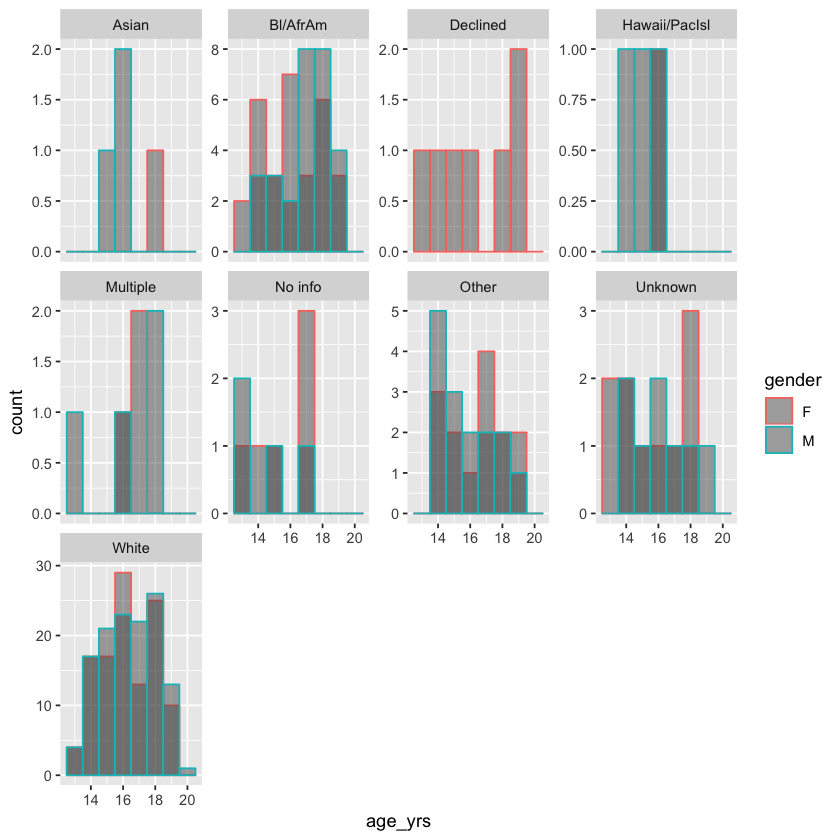

In [36]:
p <- ggplot(data = cohort, aes(x = age_yrs, color=gender)) + geom_histogram(position='identity', alpha=.5, binwidth = 1)
p + facet_wrap(~race, scales='free_y', ncol=4)

In [37]:
py = fread('cohort.csv')

In [38]:
py_ids <- c(py[, person_id])

In [48]:
for (id in py_ids){
    if (id %in% c(cohort[, person_id])) NULL
    else print(id)
}

[1] 2235


In [49]:
py[person_id == 2235]

V1,person_id,age_(yrs),gender,ethnicity,race,first_diagnosis,albut_start,days_between,age_first_d,asthma_visits,first_obese,BMI_Z,num_obese
220,2235,15.1,M,Hisp/Lat,White,2005-05-21,2006-04-28,342,2.2,12,2003-10-04,1.686596,1


In [50]:
obese[person_id == 2235]

person_id,first_obese,BMI_z
2235,2003-10-04,1.686596


In [52]:
measurement[person_id == 2235 & measurement_concept_id == '2000000043'] %>%
    arrange(measurement_date)

person_id,visit_occurrence_id,measurement_date,measurement_concept_id,measurement_id,measurement_type_concept_id,operator_concept_id,priority_concept_id,provider_id,range_high,range_high_operator_concept_id,range_low,range_low_operator_concept_id,unit_concept_id,value_as_concept_id,value_as_number
2235,26549,2003-10-04,2000000043,356345,45754907,4172703,NA,2831,NA,0,NA,0,9531,NA,1.6865962
2235,20816,2005-10-15,2000000043,355945,45754907,4172703,NA,5676,NA,0,NA,0,9531,NA,1.2778249
2235,20816,2005-10-15,2000000043,355909,45754907,4172703,NA,316255,NA,NA,NA,NA,0,NA,1.2778249
2235,48758,2006-04-28,2000000043,329391,45754907,4172703,NA,309867,NA,NA,NA,NA,0,NA,1.3909375
2235,27134,2007-04-18,2000000043,329240,45754907,4172703,NA,310059,NA,NA,NA,NA,0,NA,1.5033650
2235,20603,2007-05-09,2000000043,328970,45754907,4172703,NA,3125,NA,0,NA,0,9531,NA,1.3175068
2235,20603,2007-05-09,2000000043,329075,45754907,4172703,NA,NA,NA,NA,NA,NA,0,NA,1.3175068
2235,66597,2008-09-17,2000000043,356216,45754907,4172703,NA,2904,NA,0,NA,0,9531,NA,1.5244094
2235,66597,2008-09-17,2000000043,355886,45754907,4172703,NA,NA,NA,NA,NA,NA,0,NA,1.5244094
2235,80578,2008-12-15,2000000043,328963,45754907,4172703,NA,317505,NA,NA,NA,NA,0,NA,1.1433705
